In [1]:
from typing import TypedDict
from langgraph.graph import START,END,StateGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display

load_dotenv()

gpt_llm= ChatOpenAI(model="gpt-4o-mini")

class Cricket(TypedDict):
    balls: int
    runs: int
    fours: int
    sixes: int
    strike_rate: float
    boundary_percentage: float
    summary: str


def strike_rate_calculator(state: Cricket ) -> Cricket:
    balls=state['balls']
    runs=state['runs']

    strike_rate= (runs/balls)*100
    state['strike_rate']=strike_rate

    return {"strike_rate":strike_rate}

def boundary_percentage_calculator(state: Cricket ) -> Cricket:
    runs=state['runs']
    fours=state['fours']
    sixes=state['sixes']

    boundary_percentage= (((fours*4)+(sixes*6))/runs)*100
    state['boundary_percentage']=boundary_percentage

    return {"boundary_percentage":boundary_percentage}

def summary_generator(state: Cricket ) -> Cricket:
    runs=state['runs']
    fours=state['fours']
    sixes=state['sixes']
    strike_rate=state['strike_rate']
    boundary_percentage=state['boundary_percentage']
    

    prompt=f"""Generate a 5 line summary for the score of the player in a game of cricket.
    runs:{runs}
    fours:{fours}
    sixes:{sixes}
    strike_rate:{strike_rate}
    boundary_percentage:{boundary_percentage}
    """

    summary=gpt_llm.invoke(prompt).content

    state['summary']=summary

    return state

graph =  StateGraph(Cricket)

graph.add_node("strike_rate_calculator",strike_rate_calculator)
graph.add_node("boundary_percentage_calculator",boundary_percentage_calculator)
graph.add_node("summary_generator",summary_generator)

graph.add_edge(START,"strike_rate_calculator")
graph.add_edge(START,"boundary_percentage_calculator")
graph.add_edge("strike_rate_calculator","summary_generator")
graph.add_edge("boundary_percentage_calculator","summary_generator")
graph.add_edge("summary_generator",END)

workflow=graph.compile()

init_state= {"balls":36, "runs":67, "fours":3, "sixes":5}

final_state=workflow.invoke(init_state)

print(final_state)

{'balls': 36, 'runs': 67, 'fours': 3, 'sixes': 5, 'strike_rate': 186.11111111111111, 'boundary_percentage': 62.68656716417911, 'summary': "In an impressive display of batting, the player scored 67 runs, showcasing their aggressive style of play. They hit 3 fours and an impressive 5 sixes, contributing significantly to their team's total. With a strike rate of 186.11, the player consistently found ways to score quickly. Their boundary percentage of 62.69 reflects their ability to make impactful hits. Overall, it was a powerful performance that energized the team and spectators alike."}


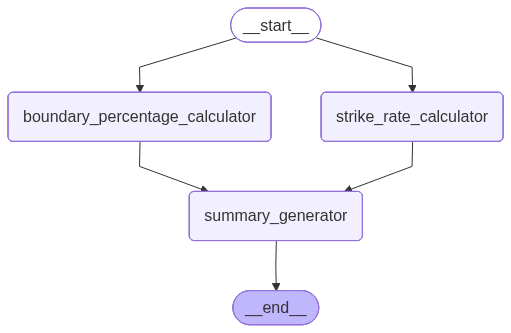

In [2]:
display(Image(workflow.get_graph().draw_mermaid_png()))